# Group 28 - MS 2.1

## Members:

Gloria Reinbacher 12322879, Fabian Rentz-Chorherr 12227731, Florian Angerer 00571472

## Task 1: Obtaining Data and Query Preparation

The Dataset was downloaded from [here](https://cdn.freesound.org/mtg-jamendo/raw_30s/audio/raw_30s_audio-28.tar). Since no problems with limited resources occured, we chose the full quality data. 

As first step we chose 20 random files from the dataset. Those files were cut to 10 second audio-snippets using Audacity. All snippets start at a random time within the first 20 seconds of the original track. 

As second step we modified each snippet in three different ways:
- Noise: added noticeable (Gaussian) noise to the snippet
- Coding: compressed the snippet highly
- Mobile: played the snippet from a laptop and recorded it with a phone with different noises in the background

This leaves us with four versions of the files: original, noise, coding, mobile. 

#### Folder structure:
- tracks: contains all the full tracks
- queries/random_selection_short: 10 second long unmodified snippets 
- queries/random_selection_noise: snippets with noise modification
- queries/random_selection_compression: snippets with coding modification
- queries/random_selection_mobile: snippets with mobile modification


## Imports

In [1]:
import os, sys
from os.path import pathsep

import numpy as np
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time

sys.path.append('..')
import libfmp.b
import libfmp.c2
import  libfmp.c6

%matplotlib inline

## Utility functions

Our utility functions are helper-functions which will be used later on in the code. Most of them are directly from Audio Identification Chapter 7, Section 1.

### Compute Constellation Map
`compute_constellation_map` computes a single constellation map with the given a spectrogram. This code is from Audio Identification Chapter 7, Section 1.

In [2]:
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (implementation using image processing)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

### Plot Constellation Map
`plot_constellation_map` plots a single constellation map with the given parameters. This code is from Audio Identification Chapter 7, Section 1.

In [3]:
def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    """Plot constellation map

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Cmap: Constellation map given as boolean mask for peak structure
        Y: Spectrogram representation (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        title: Title for plot (Default value = '')
        xlabel: Label for x-axis (Default value = 'Time (sample)')
        ylabel: Label for y-axis (Default value = 'Frequency (bins)')
        s: Size of dots in scatter plot (Default value = 5)
        color: Color used for scatter plot (Default value = 'r')
        marker: Marker for peaks (Default value = 'o')
        figsize: Width, height in inches (Default value = (7, 3))
        dpi: Dots per inch (Default value = 72)

    Returns:
        fig: The created matplotlib figure
        ax: The used axes.
        im: The image plot
    """
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im

### Compute Spectrogram
`compute_spectrogram` computes a single spetrogram given a track. Note that in the librosa.load() we specify that tracks can at most be 30 seconds long. Longer tracks will be truncated after the first 30 seconds. This code is from Audio Identification Chapter 7, Section 1.

In [4]:
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    x, Fs = librosa.load(fn_wav, sr=Fs, duration=30)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

### Compute Matching Function
`match_binary_matrices_tol` applies a maximum filter between the querry and the document and looks if the peaks match. There are some tolerances in timeing and frequency therefore the files can be a bit different and still be matched. \
`compute_matching_function` shifts loops over the document and chooses different starting points of matching the querry with the document. \
This code is from Audio Identification Chapter 7, Section 1.

In [5]:
def match_binary_matrices_tol(C_ref, C_est, tol_freq=0, tol_time=0, *, C_est_max=None):
    """
    | Compare binary matrices with tolerance
    | Note: The tolerance parameters should be smaller than the minimum distance of
      peaks (1-entries in C_ref ad C_est) to obtain meaningful TP, FN, FP values

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        C_ref (np.ndarray): Binary matrix used as reference
        C_est (np.ndarray): Binary matrix used as estimation
        tol_freq (int): Tolerance in frequency direction (vertical) (Default value = 0)
        tol_time (int): Tolerance in time direction (horizontal) (Default value = 0)

    Returns:
        TP (int): True positives
        FN (int): False negatives
        FP (int): False positives
        C_AND (np.ndarray): Boolean mask of AND of C_ref and C_est (with tolerance)
    """
    assert C_ref.shape == C_est.shape, "Dimensions need to agree"

    # Precompute filter only if not provided
    if C_est_max is None:
        C_est_max = ndimage.maximum_filter(
            C_est,
            size=(2 * tol_freq + 1, 2 * tol_time + 1),
            mode="constant",
        )

    C_AND = np.logical_and(C_est_max, C_ref)
    TP = int(np.sum(C_AND))
    FN = int(np.sum(C_ref) - TP)
    FP = int(np.sum(C_est) - TP)
    return TP, FN, FP, C_AND

In [ ]:
def compute_matching_function(C_D, C_Q, tol_freq=1, tol_time=1):
    """Computes matching function for constellation maps"""
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    assert M >= 0, "Query must be shorter than document"

    # Precompute once
    C_Q_max = ndimage.maximum_filter(
        C_Q,
        size=(2 * tol_freq + 1, 2 * tol_time + 1),
        mode="constant",
    )

    Delta = np.zeros(L, dtype=np.int32)
    for m in range(M + 1):
        C_D_crop = C_D[:, m:m + N]
        # TP = sum( C_Q_max & C_D_crop )
        Delta[m] = int(np.sum(np.logical_and(C_Q_max, C_D_crop)))

    shift_max = int(np.argmax(Delta))
    return Delta, shift_max

### Compute constellation maps
`compute_constellation_map` computes the constellation map for a single file. It first computes the spectrogram for this file, which is needed for the constellation map. \
`compute_constellation_maps` computes all constellation maps using multithreading in order to reduce copmutation time. The orignial implementations would use a for-loop.\
The code is also in parts from Audio Identification Chapter 7, Section 1.

In [7]:
from concurrent.futures import ThreadPoolExecutor

def compute_constellation_map_single(args):
    """Compute the constellation map for a single file."""
    filename, dist_freq, dist_time = args
    spectrogram = compute_spectrogram(filename)  # Perform I/O and computation
    constellation_map = compute_constellation_map(spectrogram, dist_freq, dist_time)
    return filename, constellation_map


def compute_constellation_maps(filenames, dist_freq, dist_time):
    """Compute constellation maps using multithreading."""
    # Prepare arguments for each file
    args = [(filename, dist_freq, dist_time) for filename in filenames]

    # Use ThreadPoolExecutor for multithreading
    with ThreadPoolExecutor() as executor:
        results = executor.map(compute_constellation_map_single, args)

    # Convert results to a dictionary
    Cmaps = dict(results)
    return Cmaps

### Load Filenames

`load_filenames` loads all filenames in a directory and all supdirectories.

In [8]:
def load_filenames(directory):
    filenames = []

    # os.walk yields a 3-tuple: (current_path, directories, files)
    for root, dirs, files in os.walk(directory):
        for filename in files:
            # Join the 'root' (current folder being visited) with the filename
            file_path = os.path.join(root, filename)
            filenames.append(file_path)

    return filenames

## Task 2: Database Preparation

For this task we were asked to calculate different constellation map representations by exploring different settings for the parameters $\Kappa$, $\Tau$, `tol_freq` and `tol_time` and for each parameter combination, store the constellation maps in an appropriate format for the whole database.

We have decided, that the format shall be a dictionary with the following parameter:
- parameters
    - $\Kappa$ 
    - $\Tau$
    - `tol_freq`
    - `tol_time`
- results 
    - `cmaps_D`: computed constellation maps for the database tracks
    - `cmaps_Q`: computed constellation maps for the queries
    - `matches`: dictionary to store matches between database tracks and queries
    - `hits`: summary of total and query-specific matches across different query types

We decided on a dictionary based structure, to allow clear mapping between original files and constellation maps. 

### Configurations

For the first experiment, we made a array with six configurations in total:
- three configurations spanning small, medium, and large contexts
- three (smaller, local) variations of the most promising combination of these, based on exploration and inspection of different settings.

In [9]:
configs = [
    {"kappa": 4, "tau": 4, "tol_freq": 0, "tol_time": 0, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 9, "tau": 9, "tol_freq": 0, "tol_time": 0, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 15, "tau": 15, "tol_freq": 1, "tol_time": 2, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 4, "tau": 5, "tol_freq": 1, "tol_time": 0, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 5, "tau": 5, "tol_freq":2, "tol_time": 1, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 4, "tau": 2, "tol_freq": 1, "tol_time": 1, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
]

After the initial configuration, we load all possible tracks and compute the constellation maps for each track. We store the maps in the configuration.

In [10]:
tracks = load_filenames('tracks')
for config in configs:
    config["cmaps_D"] = compute_constellation_maps(tracks, config["kappa"], config["tau"])

### Visualization of example track

Illustrated below are the constellation maps of one example track in all six configurations. We can see how the parameters $\Kappa$, $\Tau$, `tol_freq` and `tol_time` influence the map. Generally speaking we can say: the higher the values for $\Kappa$ and $\Tau$, the sparser the constellation map.

$\Kappa = 4, \Tau = 4$

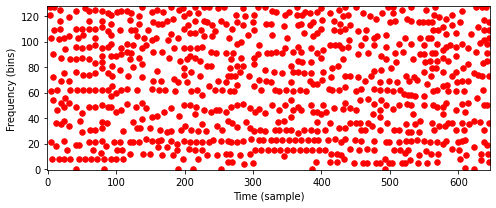

In [11]:
fig, ax, im = plot_constellation_map(configs[0]["cmaps_D"][f'tracks{os.path.sep}228.mp3'], color='r', s=30)

$\Kappa = 9, \Tau = 9$

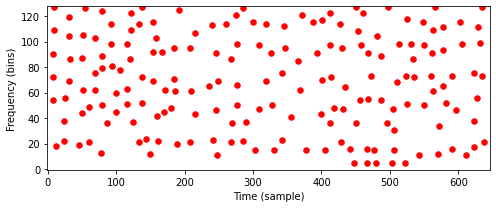

In [12]:
fig, ax, im = plot_constellation_map(configs[1]["cmaps_D"][f'tracks{os.path.sep}228.mp3'], color='r', s=30)

$\Kappa = 15, \Tau = 15$

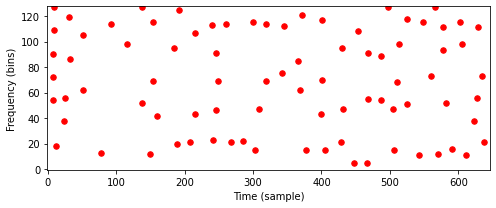

In [13]:
fig, ax, im = plot_constellation_map(configs[2]["cmaps_D"][f'tracks{os.path.sep}228.mp3'], color='r', s=30)

$\Kappa = 4, \Tau = 5$

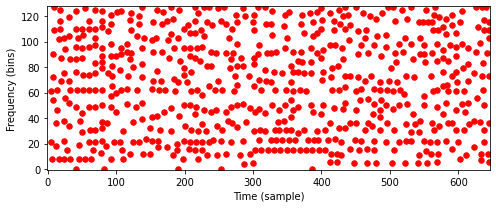

In [14]:
fig, ax, im = plot_constellation_map(configs[3]["cmaps_D"][f'tracks{os.path.sep}228.mp3'], color='r', s=30)

$\Kappa = 4, \Tau = 5$

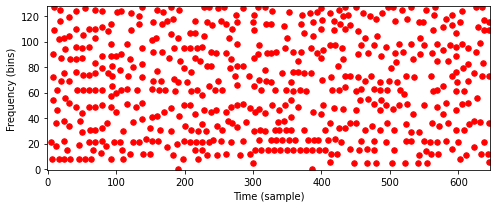

In [15]:
fig, ax, im = plot_constellation_map(configs[4]["cmaps_D"][f'tracks{os.path.sep}228.mp3'], color='r', s=30)

$\Kappa = 4, \Tau = 2$

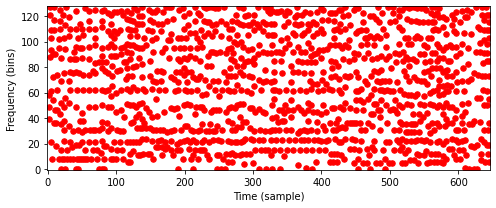

In [16]:
fig, ax, im = plot_constellation_map(configs[5]["cmaps_D"][f'tracks{os.path.sep}228.mp3'], color='r', s=30)

## Task 3

For this task we had to calculate all constellation maps for the queries from task 1, corresponding to the various settings chosen in the database preparation step.
After those are calculated, we perform the matching of the constellation map of a query with the maps of all files in the database in order to find the matches. 

In this project we stuck to a ture positives matric. This results in a match between the two tracks where the peaks alignment is best. The other advantages are that the calculation is fast and simple to implement.

The goal of this is to identify the track with the highest matching score, calculate the number of hits and report those results (graphically and tabular) as well as the average query time. This will be done in Task 4. 

We now start by loading all queries and compute the constellation maps from them. 

In [17]:
queries = load_filenames('queries')
for config in configs:
    config["cmaps_Q"] = compute_constellation_maps(queries, config["kappa"], config["tau"])

### Visualization of random example query

As in Task 2, we plot the constellation maps of a random query for each configuration. We are using the most promising combinations of the parameters $\Kappa = 4$, $\Tau = 4$, `tol_freq=0` and `tol_time=0`, meaning the last three entries from the config.

$\Kappa = 4, \Tau = 4$

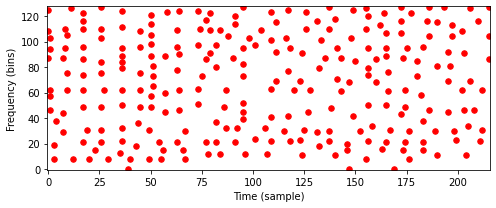

In [18]:
fig, ax, im = plot_constellation_map(configs[0]["cmaps_Q"][f'queries{os.path.sep}random_selection_short{os.path.sep}228_short.mp3'], color='r', s=30)

$\Kappa = 4, \Tau = 5$

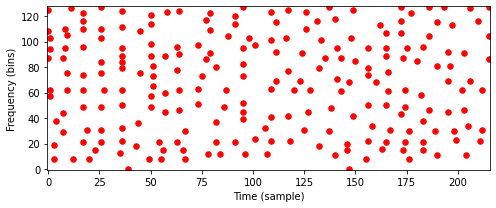

In [19]:
fig, ax, im = plot_constellation_map(configs[3]["cmaps_Q"][f'queries{os.path.sep}random_selection_short{os.path.sep}228_short.mp3'], color='r', s=30)

$\Kappa = 5, \Tau = 5$

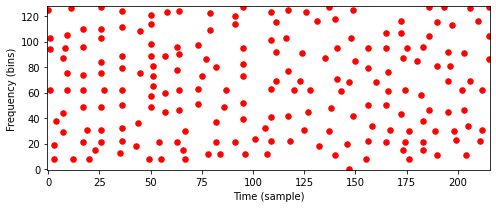

In [20]:
fig, ax, im = plot_constellation_map(configs[4]["cmaps_Q"][f'queries{os.path.sep}random_selection_short{os.path.sep}228_short.mp3'], color='r', s=30)

$\Kappa = 4, \Tau = 3$

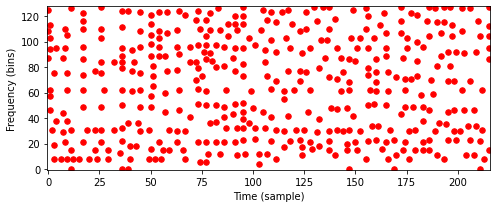

In [21]:
fig, ax, im = plot_constellation_map(configs[5]["cmaps_Q"][f'queries{os.path.sep}random_selection_short{os.path.sep}228_short.mp3'], color='r', s=30)

### Matching

In this step we match the constellation maps from our queries to the original tracks. We will do this for the most promising combinations, like shown in the step above.

The process of matching can be divided in subsections:
- for each query
    - comparing it against every track by computing the matching function of the query and the track and storing the highest score
    - storing the track corresponding to the highest score
    - calculating the hits
- for each configuration
    - calculating the overall and average time it took to match all queries
    - printing out the statistics 

In [22]:
for config in configs: # loop through all 3 configurations
    print(f"***** Configuration: κ={config['kappa']}, τ={config['tau']} *****")

    config["hits"] = {"total": 0, "short": 0, "noise": 0, "compression": 0, "mobile": 0}

    for name_Q, cmap_Q in config["cmaps_Q"].items(): # test all queries one by one
        best_score = 0
        best_name = None

        start_time = time.time() # measure time

        for name_D, cmap_D in config["cmaps_D"].items(): # compare query to all database tracks
            delta, shift_max = compute_matching_function(cmap_D, cmap_Q, tol_freq=config["tol_freq"], tol_time=config["tol_time"])

            if delta[shift_max] > best_score:
                best_score = delta[shift_max]
                best_name = name_D


        end_time = time.time()

        # save best matching track
        config["matches"][name_Q] = {"matching_track": best_name, "score": best_score, "time": (end_time-start_time)}

        # keep track of hits - it is a hit if the track number of the query filename is the same as of the track filename
        track_num = name_Q.split(os.path.sep)[2].split('_')[0]
        if track_num in best_name:
            config["hits"]["total"] += 1 # total hits

            if "noise" in name_Q:
                config["hits"]["noise"] += 1 # if query was a noise query
            elif "10k_16k" in name_Q:
                config["hits"]["compression"] += 1 # if query was a coding query
            elif "mobile" in name_Q:
                config["hits"]["mobile"] += 1 # if query was a mobile query
            elif "short" in name_Q:
                config["hits"]["short"] += 1 # if query the orginal extracted segment


    total_time = sum(entry["time"] for entry in config["matches"].values()) # total time it took for all queries of the given configuration
    average_time = total_time / len(config["matches"]) if config["matches"] else 0 # average query time of given configuration

    # print out short statistics for each configuration
    print(f"Average time per query: {average_time:.2f} seconds")
    print(f"Matched {config['hits']['total']} of {len(queries)} queries correctly.")
    print(f"Short: {config['hits']['short']} / {20}.")
    print(f"Noise: {config['hits']['noise']} / {20}.")
    print(f"Compression: {config['hits']['compression']} / {20}.")
    print(f"Mobile: {config['hits']['mobile']} / {20}.")

    print("\n\n")

***** Configuration: κ=4, τ=4 *****
Average time per query: 2.59 seconds
Matched 69 of 80 queries correctly.
Short: 20 / 20.
Noise: 19 / 20.
Compression: 20 / 20.
Mobile: 10 / 20.



***** Configuration: κ=9, τ=9 *****
Average time per query: 2.60 seconds
Matched 65 of 80 queries correctly.
Short: 20 / 20.
Noise: 19 / 20.
Compression: 20 / 20.
Mobile: 6 / 20.



***** Configuration: κ=15, τ=15 *****
Average time per query: 2.67 seconds
Matched 62 of 80 queries correctly.
Short: 20 / 20.
Noise: 19 / 20.
Compression: 20 / 20.
Mobile: 3 / 20.



***** Configuration: κ=4, τ=5 *****
Average time per query: 2.64 seconds
Matched 64 of 80 queries correctly.
Short: 20 / 20.
Noise: 19 / 20.
Compression: 20 / 20.
Mobile: 5 / 20.



***** Configuration: κ=5, τ=5 *****
Average time per query: 2.68 seconds
Matched 64 of 80 queries correctly.
Short: 20 / 20.
Noise: 19 / 20.
Compression: 20 / 20.
Mobile: 5 / 20.



***** Configuration: κ=4, τ=2 *****
Average time per query: 2.67 seconds
Matched 63 of 

## Task 4

The system was evaluated using a set of generated queries derived from the reference audio tracks. Queries were grouped into the categories: short excerpts, gaussian noise, compression artifacts, and mobile-recorded.

A central design decision concerns the choice of fingerprint matching parameters, in particular the parameters κ (kappa) and τ (tau). These parameters control the matching function by weighting the contribution of coinciding fingerprint peaks and the temporal alignment tolerance. Smaller tolerance values increase precision but may fail under distortions, while larger tolerances improve robustness at the risk of increased false positives.

Another important design choice was the use of a maximum matching score decision rule: for each query, the database track with the highest matching score was selected as the predicted match. This choice reflects a Top-1 identification scenario, which is appropriate for applications such as song identification but is also sensitive to score ambiguities when multiple candidates achieve similar scores.

The results show that the system performs reliably on clean and mildly distorted queries, achieving a high number of correct matches for the total and short query categories. Performance degrades for noise, compression, and mobile-recorded queries, which is expected due to the loss or displacement of fingerprint peaks under these distortions.

Across configurations, increasing tolerance parameters generally improves robustness for noisy and mobile queries, but at the cost of reduced discrimination between similar tracks. This trade-off is visible in the aggregated statistics, where configurations with larger tolerances yield higher average matching scores but do not always improve the number of correct identifications.

Visualizations in the report illustrate these effects by comparing the number of successful matches per category and configuration, as well as the average matching scores. These plots highlight that good average scores do not necessarily imply better identification accuracy, emphasizing the importance of evaluating both metrics.

A limitation of the current evaluation is the exclusive focus on Top-1 accuracy. Queries where the correct track appears as the second or third best match are counted as failures, even though such results may still be useful in practical systems. Extending the evaluation to Top-k accuracy would provide a more nuanced view of system performance.

The matching score margin between the best and second-best candidates was not analyzed. Small margins would indicate unstable decisions, which is particularly relevant for noisy or compressed queries.

Finally, the parameter search space for κ, τ, and tolerance values was limited for computational reasons. A more systematic parameter sweep or data-driven optimization could further improve performance and robustness.

In [23]:
import pandas as pd

# Example data
average_times = []
for config in configs:
    total_time = sum(entry["time"] for entry in config["matches"].values())
    average_time = total_time / len(config["matches"]) if config["matches"] else 0
    average_times.append(average_time)

max_times = [max(entry["time"] for entry in config["matches"].values()) for config in configs]
min_times = [min(entry["time"] for entry in config["matches"].values()) for config in configs]



data = {
    "Average Query Time (sec)": average_times,
    "Max Query Time (sec)": max_times,
    "Min Query Time (sec)": min_times,
    "Total Accuracy (%)": [config["hits"]["total"]/len(queries) for config in configs],
    "Short Accuracy (%)": [(config["hits"]["short"]/20)*100 for config in configs],
    "Noise Accuracy (%)": [(config["hits"]["noise"]/20)*100 for config in configs],
    "Compression Accuracy (%)": [(config["hits"]["compression"]/20)*100 for config in configs],
    "Mobile Accuracy (%)": [(config["hits"]["mobile"]/20)*100 for config in configs],
}

# Row labels
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]

# Create the DataFrame
df = pd.DataFrame(data, index=labels)
df

,Average Query Time (sec),Max Query Time (sec),Min Query Time (sec),Total Accuracy (%),Short Accuracy (%),Noise Accuracy (%),Compression Accuracy (%),Mobile Accuracy (%)
"kappa=4, tau=4",2.592076,2.772177,2.526086,0.8625,100.0,95.0,100.0,50.0
"kappa=9, tau=9",2.603389,2.773544,2.544957,0.8125,100.0,95.0,100.0,30.0
"kappa=15, tau=15",2.671936,2.826187,2.628793,0.7750,100.0,95.0,100.0,15.0
"kappa=4, tau=5",2.640574,2.796437,2.606738,0.8000,100.0,95.0,100.0,25.0
"kappa=5, tau=5",2.680201,2.880901,2.606807,0.8000,100.0,95.0,100.0,25.0
"kappa=4, tau=2",2.670983,2.847034,2.629236,0.7875,100.0,90.0,100.0,25.0


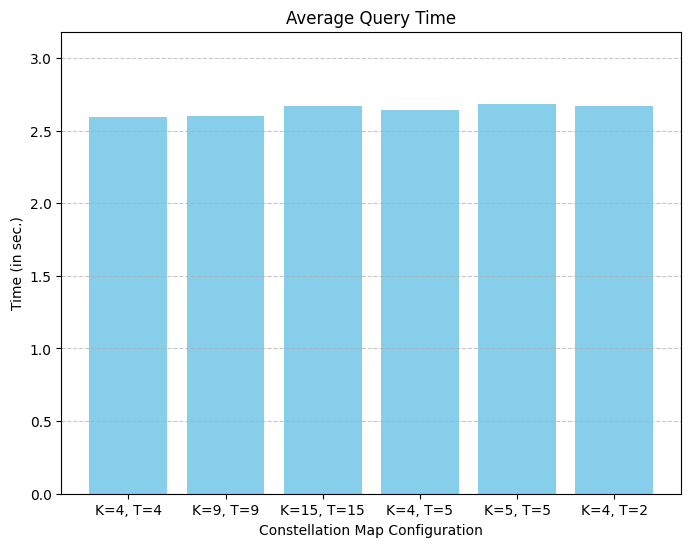

In [24]:
import matplotlib.pyplot as plt

# Values to plot
labels = [f"K={config['kappa']}, T={config['tau']}" for config in configs]
values = []

for config in configs:
    total_time = sum(entry["time"] for entry in config["matches"].values())
    average_time = total_time / len(config["matches"]) if config["matches"] else 0
    values.append(average_time)

# Creating the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='skyblue')
plt.title('Average Query Time')
plt.xlabel('Constellation Map Configuration')
plt.ylabel('Time (in sec.)')
plt.ylim(0, max(values) + 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

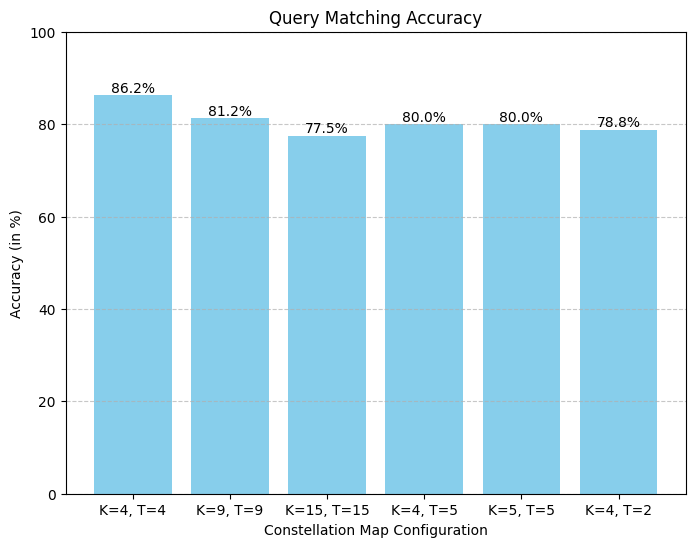

In [25]:
import matplotlib.pyplot as plt


# Values to plot
labels = [f"K={config['kappa']}, T={config['tau']}" for config in configs]
values = [config["hits"]["total"]/len(queries)*100 for config in configs]


# Creating the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color='skyblue')

# Adding percentages above the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

# Adding title and labels
plt.title('Query Matching Accuracy')
plt.xlabel('Constellation Map Configuration')
plt.ylabel('Accuracy (in %)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

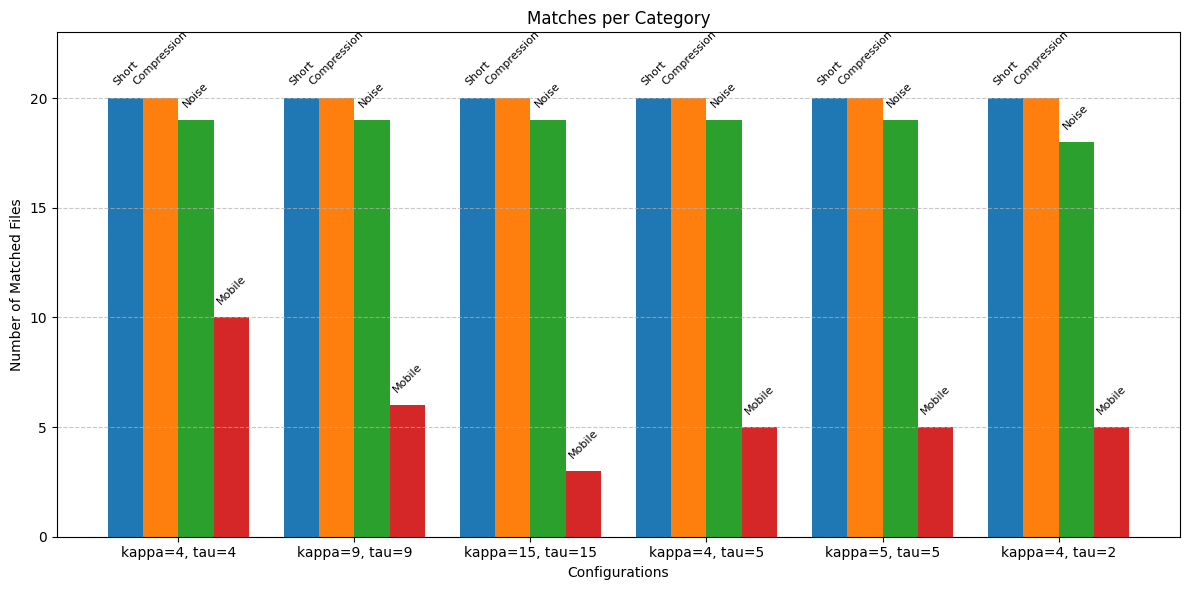

In [26]:
# Configuration names and corresponding counts for each category
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]
matched_original = [config["hits"]["short"] for config in configs]
matched_coding = [config["hits"]["compression"] for config in configs]
matched_noise = [config["hits"]["noise"] for config in configs]
matched_mobile = [config["hits"]["mobile"] for config in configs]

# Number of configurations
num_configs = len(labels)

# X positions for groups of bars
x = np.arange(num_configs)

# Width of each bar
bar_width = 0.2

# Categories and their data
categories = ['Short', 'Compression', 'Noise', 'Mobile']
data = [matched_original, matched_coding, matched_noise, matched_mobile]

# Plot
plt.figure(figsize=(12, 6))

for i, category_data in enumerate(data):
    # Offset for each bar in a group
    bar_positions = x + (i - 1.5) * bar_width
    bars = plt.bar(bar_positions, category_data, width=bar_width)

    # Add category labels on top of each bar
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,  # Adjusted offset for more space
                 categories[i], ha='center', va='bottom', rotation=45, fontsize=8)

# Add labels, title, and legend
plt.xlabel('Configurations')
plt.ylabel('Number of Matched Files')
plt.title('Matches per Category')
plt.xticks(x, labels)

# Adjust the y-axis to leave more space at the top
plt.ylim(0, max(max(matched_original), max(matched_coding), max(matched_noise), max(matched_mobile)) + 3)

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


------------------

kappa: 4 | tau: 4 | tol_freq: 0 | tol_time: 0
Maximum Score:
                                             Query  Score
7  queries/random_selection_short/24028_short.mp3    268

Minimum Score:
                                                Query  Score
71  queries/random_selection_mobile/25228_mobile.mp3     12

Average Score: 90.6125
Average Score for `original` Queries: 159.9
Average Score for `mobile` Queries: 16.9
Average Score for `coding` Queries: 63.5
Average Score for `noise` Queries: 122.15

------------------

kappa: 9 | tau: 9 | tol_freq: 0 | tol_time: 0
Maximum Score:
                                              Query  Score
15  queries/random_selection_short/31428_short.mp3     74

Minimum Score:
                                             Query  Score
58  queries/random_selection_noise/4628_noise.mp3      4

Average Score: 23.4875
Average Score for `original` Queries: 38.35
Average Score for `mobile` Queries: 5.0
Average Score for `coding` Queries: 

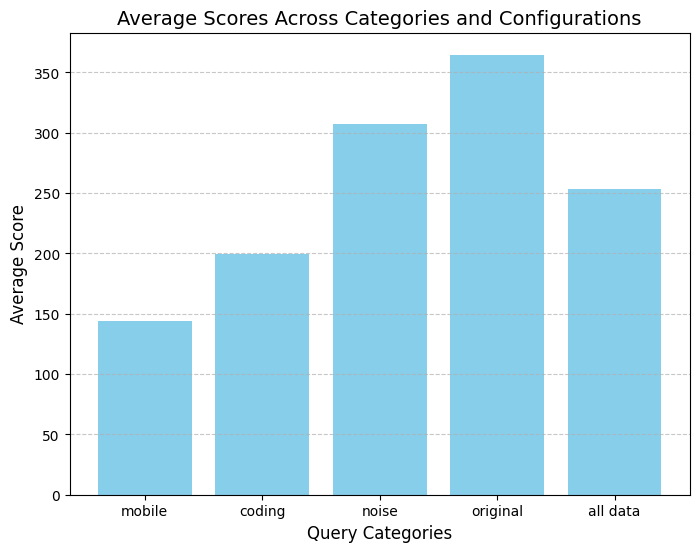

In [34]:
keys_to_print = ['kappa', 'tau', 'tol_freq', 'tol_time']
print("\n------------------\n")

for config in configs:
    key_values = " | ".join(f"{key}: {config[key]}" for key in keys_to_print if key in config)
    print(f"{key_values}")

    # Extract matches data
    matches_data = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
    ]
    matches_data_mobile = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
        if "mobile" in query_name.lower()
    ]
    matches_data_code = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
        if "compression" in query_name.lower()
    ]
    matches_data_noise = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
        if "noise" in query_name.lower()
    ]
    matches_data_original = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
        if "short" in query_name.lower()
    ]

    average_scores = {"mobile": [], "coding": [], "noise": [], "original": [], "all data": []}

    # Create DataFrames
    df = pd.DataFrame(matches_data)
    df_m = pd.DataFrame(matches_data_mobile)
    df_c = pd.DataFrame(matches_data_code)
    df_n = pd.DataFrame(matches_data_noise)
    df_o = pd.DataFrame(matches_data_original)

    # Ensure "Score" column is numeric where applicable
    df["Score"] = pd.to_numeric(df["Score"])
    average_score_m = None
    if not df_m.empty:
        df_m["Score"] = pd.to_numeric(df_m["Score"])
        average_score_m = df_m["Score"].mean()
    average_score_c = None
    if not df_c.empty:
        df_c["Score"] = pd.to_numeric(df_c["Score"])
        average_score_c = df_c["Score"].mean()
    average_score_n = None
    if not df_n.empty:
        df_n["Score"] = pd.to_numeric(df_n["Score"])
        average_score_n = df_n["Score"].mean()
    average_score_o = None
    if not df_o.empty:
        df_o["Score"] = pd.to_numeric(df_o["Score"])
        average_score_o = df_o["Score"].mean()

    for category, matches in zip(
        ["mobile", "coding", "noise", "original", "all data"],
        [df_m, df_c, df_n, df_o, df]
    ):
        df = pd.DataFrame(matches)
        if not df.empty:
            df["Score"] = pd.to_numeric(df["Score"])
            average_scores[category].append(df["Score"].mean())

    # Calculate max, min, and average for all queries
    max_row = df.nlargest(1, "Score")
    min_row = df.nsmallest(1, "Score")
    average_score = df["Score"].mean()

    # Print Results
    print("Maximum Score:\n", max_row)
    print("\nMinimum Score:\n", min_row)
    print("\nAverage Score:", average_score)
    print("Average Score for `original` Queries:", average_score_o)
    print("Average Score for `mobile` Queries:", average_score_m)
    print("Average Score for `coding` Queries:", average_score_c)
    print("Average Score for `noise` Queries:", average_score_n)
    print("\n------------------\n")

final_averages = {cat: pd.Series(scores).mean() for cat, scores in average_scores.items() if scores}

plt.figure(figsize=(8, 6))
categories = list(final_averages.keys())
scores = list(final_averages.values())

plt.bar(categories, scores, color='skyblue')
plt.title("Average Scores Across Categories and Configurations", fontsize=14)
plt.xlabel("Query Categories", fontsize=12)
plt.ylabel("Average Score", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()